# Figure 2

In [2]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import PIL
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Utils.bar_utils import BarRenderer

In [3]:
# Load human data
file_name = 'all_data.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
data['model'] = data.apply(lambda row: f"{row['room']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
data['num_players'] = data['num_players'].astype(int)
data['round'] = data['round'].astype(int)
data['decision'] = data['decision'].astype(int)
data['group'] = data['group'].apply(lambda x: x.split('-')[0] if 'Grupo' not in x else x.split('-')[1])

# data = data[data['threshold'] != 1]
data.drop(columns=['room', 'date', 'timeup', 'time', 'attendance', 'ac_score', 'choice'], inplace=True)

Loading data from /Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/human/all_data.csv...


In [4]:
# Change round to round within session
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions
    
group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)

def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
# data['group'] = data.apply(lambda row: f"{row['group']}-{row['session']}", axis=1)
# data = data[data['round'] <= 30]

data.sort_values(by=['num_players', 'threshold'], inplace=True)

print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))
data.head(2)

Group sizes: 2, 3, 4, 5, 6, 7, 8, 9, 11, 12
Number of groups: 51


,source,treatment,group,round,player,score,threshold,num_players,decision,model,session
0,humans,score + grid,0001,0,405186428721292,0.0,0.5,2,0,Grupo-0001-2-0.50,1
1,humans,score + grid,0001,0,728608683559397,1.0,0.5,2,1,Grupo-0001-2-0.50,1


In [5]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality', 'bounded_inequality'],
    T=25
)
df = gm.get_measurements()

# Find coordination type
alt_index = AlternationIndex.from_file(priority='mlp')
df['predicted_class'] = alt_index.classify(df)

In [6]:
df_best = df[df['bounded_efficiency'] > 0.5]
df_best = df_best[df_best['threshold'] < 1]

# df_best['model'] = df_best.apply(lambda row: f"{row['model']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
df_best.sort_values(by=['bounded_efficiency', 'num_players'], ascending=False, inplace=True)
print('Num. of best sessions:', len(df_best))
# df_best

Num. of best sessions: 27


### Playout examples

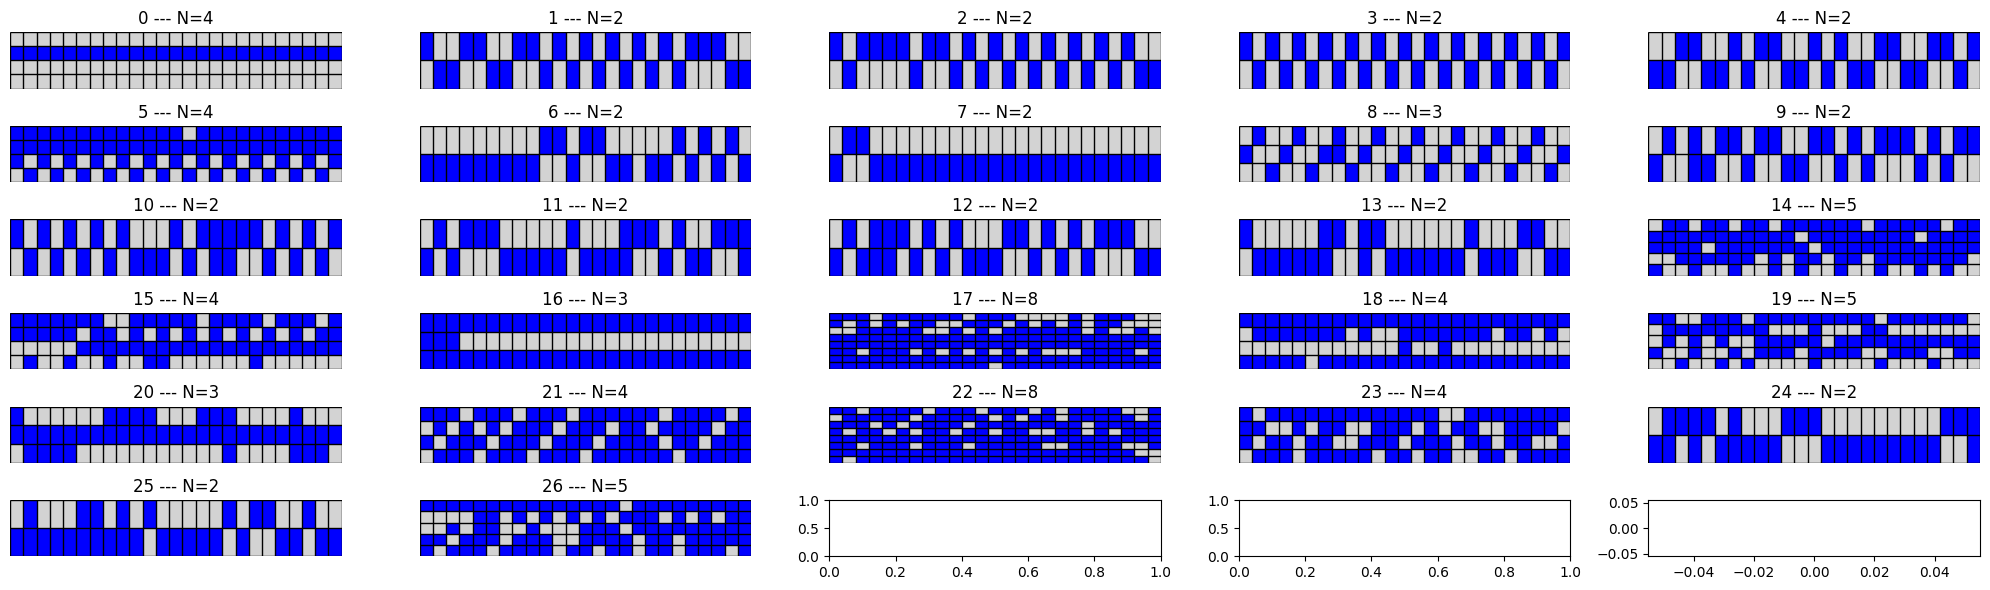

In [11]:
groups = df_best['model'].unique()
# keep_groups_idx = [
#     4, 3, 2, 
#     1, 6, 7, 
#     8, 19, 17, 
#     16, 5, 15, 
#     20, 21, 24
# ]
# groups = np.array(df_best['model'].unique())[keep_groups_idx].tolist()
categories = [
    'alternation', 'alternation', 'alternation',
    'alternation', 'alternation', 'segmentation',
    'alternation', 'mixed', 'segmentation',
    'alternation', 'mixed', 'mixed',
    'segmentation', 'mixed', 'mixed'
]

grid = Grid(len(groups), vertical=True)

fig, axes = plt.subplots(
    grid.rows, grid.cols, 
    figsize=(grid.cols*4, grid.rows),
    tight_layout=True
)

for i, group in enumerate(groups):
    df_aux = df_best[df_best['model'] == group]
    df_aux_aux = data[data['model'] == group]
    threshold = df_aux['threshold'].unique()[0]
    BE = df_aux['bounded_efficiency'].unique()[0]
    N = df_aux_aux['num_players'].values[0]
    B = int(df_aux_aux['threshold'].values[0] * N)
    # classification = df_aux['predicted_class'].values[0]
    # classification = categories[i]
    classification = i
    bar_renderer = BarRenderer(data=df_aux_aux)
    bar_renderer.render(
        ax=axes[grid.index_to_pair(i)],
        # title=f"N={N}, B={B}, B.E.={BE:.2f}, Type={classification}",
        title=f"{i} --- N={N}",
        num_rounds=25
    )

In [8]:
fig.savefig(PATHS['figures_for_paper'] / 'Short_Fig2.png', dpi=300, bbox_inches='tight')

---

In [9]:
df['predicted_class'] = alt_index.classify(data)
df_ = df.groupby('num_players')['predicted_class'].value_counts(normalize=True).reset_index()
df_categories = pd.pivot_table(
    data=df_,
    index='num_players',
    columns='predicted_class',
    values='proportion'
).fillna('-')
df_categories

KeyError: "None of [Index(['bounded_efficiency', 'inequality'], dtype='object')] are in the [columns]"

In [ ]:
df['predicted_class'].value_counts(normalize=False).reset_index()